In [1]:
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import defaultdict

import pandas as pd
import random
import os
import numpy as np

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42) # Seed 고정

In [3]:
def single_lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여

    rmse = metrics.mean_squared_error(gt, preds, squared=False)
    nrmse = rmse/np.mean(np.abs(gt))

    return nrmse

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
class CustomDataset(Dataset):
    def __init__(self, x, y=None, norm=False):
        self.x = torch.Tensor(x.values)
        if norm:
            self.x = normalize(self.x, p=2.0)
        
        self.test = True if y is None else False
        if not self.test:
            self.y = torch.Tensor(y.values).reshape(-1, 1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if self.test:
            return self.x[idx]
        return self.x[idx], self.y[idx]

In [35]:
class CustomModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(56, 128),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            # nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 14)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        for _ in range(10):
            out = self.layer2(out)
        out = self.layer3(out)
        return out

In [48]:
class CustomModel2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 56),
            nn.ReLU(),
  
            nn.Linear(56, 42),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(42, 28),
            nn.ReLU(),
            
            nn.Linear(28, 14),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(14, 14),
            nn.ReLU(),
            # nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(14, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.layer1(x)
        # for _ in range(10):
        #     out = self.layer2(out)
        out = self.layer3(out)
        return out

In [37]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(56, 512)
        self.layer1 = self.make_layers(512, num_repeat=30)
        self.relu = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 14)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = nn.Dropout(0.2)(x)
        x = self.fc5(x)
        return x

    def make_layers(self, value, num_repeat):
        layers = []
        for _ in range(num_repeat):
            layers.append(nn.Linear(value, value))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

In [10]:
class NormalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(52, 26),
            nn.ReLU(),
  
            nn.Linear(26, 13),
            nn.ReLU(),
        )
        
        self.layer1 = nn.Sequential(
            nn.Linear(13, 26),
            nn.ReLU(),
  
            nn.Linear(26, 1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [8]:
df = pd.read_csv('anomaly_detection_train.csv').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])
    
train_df, valid_df = train_test_split(df, train_size=0.8)
len(df), len(train_df), len(valid_df)

(39607, 31685, 7922)

In [62]:
epochs = 1000
lr = 6e-5
bs = 2048

In [63]:
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.Abnormal # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.Abnormal # Output : Y Feature

test_x = pd.read_csv('./test.csv').drop(columns=['ID']).drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])

score = defaultdict(int)

submit = pd.read_csv('./sample_submission.csv')

train_ds = CustomDataset(train_x, train_y, True)
valid_ds = CustomDataset(valid_x, valid_y, True)
test_ds = CustomDataset(test_x)

train_dl = DataLoader(
    dataset=train_ds,
    batch_size=bs,
    shuffle=True,
    drop_last=False,
)
valid_dl = DataLoader(
    dataset=valid_ds,
    batch_size=bs
)
test_dl = DataLoader(
    dataset=test_ds,
    batch_size=bs
)

model = CustomModel2(input_dim=len(train_x.columns)).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# train_losses = np.zeros(epochs+1)
# valid_losses = np.zeros(epochs+1)

for epoch in range(epochs+1):
    model.train()
    # train_pbar = tqdm(train_dl)
    for idx, (inputs, labels) in enumerate(train_dl, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outs = model(inputs)
        loss = criterion(outs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # train_losses[epoch] += loss.item()
        # train_pbar.set_description(f'TRAIN | epoch : {epoch} | loss : {train_losses[epoch] / (bs * idx)}')

    if epoch % 10 == 0:
        with torch.no_grad():
            model.eval()
            valid_pbar = tqdm(valid_dl)
            for idx, (inputs, labels) in enumerate(valid_pbar, 1):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outs = model(inputs)
                loss = criterion(outs, labels)

                # valid_losses[epoch] += loss.item()
                valid_pbar.set_description(f'VALID | epoch : {epoch} | loss : {loss.item() / (bs * idx)}')

        out = model(normalize(torch.Tensor(valid_x.values).to(device)))
        pred = out.cpu().detach().numpy()
        
        list(valid_y.values == np.reshape(pred, (-1,))).count(True)
        # print((valid_y.values == pred))
        

out = model(normalize(torch.Tensor(test_x.values).to(device)))
pred = out.cpu().detach().numpy()

VALID | epoch : 0 | loss : 0.00011041918332921341: 100%|██████████| 4/4 [00:00<00:00, 109.34it/s]
VALID | epoch : 10 | loss : 0.00010956822370644659: 100%|██████████| 4/4 [00:00<00:00, 125.86it/s]
VALID | epoch : 20 | loss : 0.00010835591820068657: 100%|██████████| 4/4 [00:00<00:00, 104.23it/s]
VALID | epoch : 30 | loss : 0.00010645180736901239: 100%|██████████| 4/4 [00:00<00:00, 119.04it/s]
VALID | epoch : 40 | loss : 0.00010163531987927854: 100%|██████████| 4/4 [00:00<00:00, 48.44it/s]
VALID | epoch : 50 | loss : 9.336429502582178e-05: 100%|██████████| 4/4 [00:00<00:00, 103.59it/s]
VALID | epoch : 60 | loss : 8.783492376096547e-05: 100%|██████████| 4/4 [00:00<00:00, 132.38it/s]
VALID | epoch : 70 | loss : 8.596624684287235e-05: 100%|██████████| 4/4 [00:00<00:00, 98.92it/s]
VALID | epoch : 80 | loss : 8.52761950227432e-05: 100%|██████████| 4/4 [00:00<00:00, 101.97it/s]
VALID | epoch : 90 | loss : 8.498922397848219e-05: 100%|██████████| 4/4 [00:00<00:00, 98.05it/s]
VALID | epoch : 100 

In [68]:
pd.DataFrame((out >= torch.FloatTensor([0.5]).to(device)).cpu().detach().numpy()).value_counts()

False    39608
dtype: int64

In [186]:
epochs = 800
lr = 6e-5
bs = 2048
order = ['14', '13', '12', '11', '10', '09', '08', '05', '06', '07', '04', '01', '02', '03']
lrs = [3e-5, ]

In [187]:
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature

test_x = pd.read_csv('./test.csv').drop(columns=['ID'])

train_pred = pd.DataFrame()
valid_pred = pd.DataFrame()
test_pred = pd.DataFrame()
score = defaultdict(int)

submit = pd.read_csv('./sample_submission.csv')

order_bar = tqdm(enumerate(order))
for idx, col in order_bar:
    col = 'Y_' + col
    
    train_x = pd.concat([train_x, train_pred], axis=1)
    valid_x = pd.concat([valid_x, valid_pred], axis=1)
    test_x = pd.concat([test_x, test_pred], axis=1)
    
    train_ds = CustomDataset(train_x, train_y[col], True)
    valid_ds = CustomDataset(valid_x, valid_y[col], True)
    test_ds = CustomDataset(test_x)
    
    train_dl = DataLoader(
        dataset=train_ds,
        batch_size=bs,
        shuffle=True,
        drop_last=False,
    )
    valid_dl = DataLoader(
        dataset=valid_ds,
        batch_size=bs
    )
    test_dl = DataLoader(
        dataset=test_ds,
        batch_size=bs
    )
    
    model = CustomModel2(input_dim=train_x.shape[1]).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train_losses = np.zeros(epochs+1)
    # valid_losses = np.zeros(epochs+1)

    for epoch in range(epochs+1):
        model.train()
        # train_pbar = tqdm(train_dl)
        for idx, (inputs, labels) in enumerate(train_dl, 1):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            loss = criterion(outs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # train_losses[epoch] += loss.item()
            # train_pbar.set_description(f'TRAIN | epoch : {epoch} | loss : {train_losses[epoch] / (bs * idx)}')

        if epoch % 10 == 0:
            with torch.no_grad():
                model.eval()
                # valid_pbar = tqdm(valid_dl)
                for idx, (inputs, labels) in enumerate(valid_dl, 1):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outs = model(inputs)
                    loss = criterion(outs, labels)

                    # valid_losses[epoch] += loss.item()
                    # valid_pbar.set_description(f'VALID | epoch : {epoch} | loss : {loss.item() / (bs * idx)}')
        
            out = model(normalize(torch.Tensor(valid_x.values).to(device)))
            pred = out.cpu().detach().numpy()
            valid_pred = pd.DataFrame(pred, columns=[col])
            s = single_lg_nrmse(valid_y[[col]], valid_pred)
            order_bar.set_description(f"col {col} | epoch {epoch} | score {s.values[0]}")
            # print(f"col {col} | epoch {epoch} | score {s.values if idx <= 6 else s * 1.2}")
            
    out = model(normalize(torch.Tensor(train_x.values).to(device)))
    pred = out.cpu().detach().numpy()
    train_pred = pd.DataFrame(pred, index=train_x.index, columns=[col])

    out = model(normalize(torch.Tensor(valid_x.values).to(device)))
    pred = out.cpu().detach().numpy()
    valid_pred = pd.DataFrame(pred, index=valid_x.index, columns=[col])

    s = single_lg_nrmse(valid_y[[col]], valid_pred)
    score[col] = s
    print(f"col {col} | score {score[col]}")

    out = model(normalize(torch.Tensor(test_x.values).to(device)))
    pred = out.cpu().detach().numpy()
    test_pred = pd.DataFrame(pred, index=test_x.index, columns=[col])

    submit[col] = test_pred[col]
    
submit.to_csv('mlp_chain.csv', index=False)
score

col Y_03 | epoch 800 | score 0.3548850656262399: : 14it [34:14, 146.72s/it] 


defaultdict(int,
            {'Y_14': Y_14    0.024977
             dtype: float64,
             'Y_13': Y_13    0.024961
             dtype: float64,
             'Y_12': Y_12    0.025048
             dtype: float64,
             'Y_11': Y_11    0.03379
             dtype: float64,
             'Y_10': Y_10    0.041954
             dtype: float64,
             'Y_09': Y_09    0.024858
             dtype: float64,
             'Y_08': Y_08    0.025085
             dtype: float64,
             'Y_05': Y_05    0.080341
             dtype: float64,
             'Y_06': Y_06    0.129761
             dtype: float64,
             'Y_07': Y_07    0.13441
             dtype: float64,
             'Y_04': Y_04    0.192026
             dtype: float64,
             'Y_01': Y_01    0.263518
             dtype: float64,
             'Y_02': Y_02    0.364571
             dtype: float64,
             'Y_03': Y_03    0.354885
             dtype: float64})

In [48]:
train_ds = CustomDataset(train_x, train_y, False)
valid_ds = CustomDataset(valid_x, valid_y, False)
# test_ds = CustomDataset(test_x)

In [49]:
train_dl = DataLoader(
    dataset=train_ds,
    batch_size=bs,
    shuffle=True,
    drop_last=True
)
valid_dl = DataLoader(
    dataset=valid_ds,
    batch_size=bs
)
# test_dl = DataLoader(
#     dataset=test_ds,
#     batch_size=bs
# )

In [50]:
model = CustomModel2().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = np.zeros(epochs)
valid_losses = np.zeros(epochs)

for epoch in range(epochs):
    model.train()
    # train_pbar = tqdm(train_dl)
    for idx, (inputs, labels) in enumerate(train_dl, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outs = model(inputs)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_losses[epoch] += loss.item()
        # train_pbar.set_description(f'TRAIN | epoch : {epoch} | loss : {train_losses[epoch] / (bs * idx)}')
    
    # if epoch % 10 == 0:
    with torch.no_grad():
        model.eval()
        valid_pbar = tqdm(valid_dl)
        for idx, (inputs, labels) in enumerate(valid_pbar, 1):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            loss = criterion(outs, labels)

            valid_losses[epoch] += loss.item()
            valid_pbar.set_description(f'VALID | epoch : {epoch} | loss : {valid_losses[epoch] / (bs * idx)}')

VALID | epoch : 0 | loss : 0.23391412571072578: 100%|██████████| 4/4 [00:00<00:00, 122.97it/s]
VALID | epoch : 1 | loss : 0.198810875415802: 100%|██████████| 4/4 [00:00<00:00, 114.76it/s]
VALID | epoch : 2 | loss : 0.18329662457108498: 100%|██████████| 4/4 [00:00<00:00, 120.01it/s]
VALID | epoch : 3 | loss : 0.15190701186656952: 100%|██████████| 4/4 [00:00<00:00, 109.81it/s]
VALID | epoch : 4 | loss : 0.13421250134706497: 100%|██████████| 4/4 [00:00<00:00, 116.06it/s]
VALID | epoch : 5 | loss : 0.11272305808961391: 100%|██████████| 4/4 [00:00<00:00, 109.11it/s]
VALID | epoch : 6 | loss : 0.08562113530933857: 100%|██████████| 4/4 [00:00<00:00, 131.57it/s]
VALID | epoch : 7 | loss : 0.06340428069233894: 100%|██████████| 4/4 [00:00<00:00, 132.27it/s]
VALID | epoch : 8 | loss : 0.0420817481353879: 100%|██████████| 4/4 [00:00<00:00, 124.84it/s]
VALID | epoch : 9 | loss : 0.02875805413350463: 100%|██████████| 4/4 [00:00<00:00, 142.65it/s]
VALID | epoch : 10 | loss : 0.019233152735978365: 100

KeyboardInterrupt: 

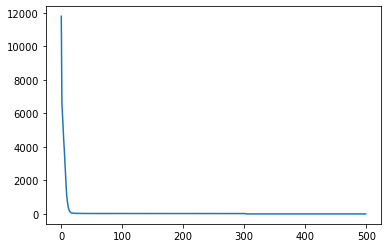

In [51]:
plt.plot(train_losses)

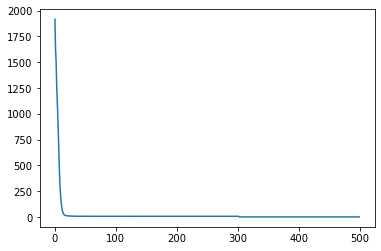

In [52]:
plt.plot(valid_losses)

In [56]:
# out = model(normalize(torch.Tensor(valid_x.values).to(device)))
out = model(torch.Tensor(valid_x.values).to(device))
pred = out.cpu().detach().numpy()
lg_nrmse(valid_y.values, pred)

(2.054609121318559,
 [0.2674817823540884,
  0.3722135967839395,
  0.3684801572528793,
  0.19208452877506185,
  0.08168081741184877,
  0.11295364202021745,
  0.13683973089992063,
  0.02744921075022953,
  0.02671255208534405,
  0.04160517355426905,
  0.035539534060968846,
  0.026730142595640678,
  0.025705058572031213,
  0.027296500952482594])

In [344]:
class CustomDataset2(Dataset):
    def __init__(self, x, pred, y=None, norm=False):
        self.x = torch.Tensor(x.values)
        if norm:
            self.x = normalize(self.x, p=2.0)
        self.x = torch.cat([self.x, pred], dim=1)
        
        self.test = True if y is None else False
        if not self.test:
            self.y = torch.Tensor(y.values)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if self.test:
            return self.x[idx]
        return self.x[idx], self.y[idx]

In [ ]:
df = pd.read_csv('./train.csv')

train_df, valid_df = train_test_split(df, train_size=0.8)
len(df), len(train_df), len(valid_df)

train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature

test_x = pd.read_csv('./test.csv').drop(columns=['ID'])

epochs = 1000
lr = 2e-4
bs = 2048

model = CustomModel2().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

renewal = 50
train_losses = torch.Tensor(np.zeros(epochs))
valid_losses = torch.Tensor(np.zeros(epochs))

for epoch in range(epochs):
    if epoch % renewal == 0:
        print(f"{'*'*3} Output Chain at epoch {epoch} {'*'*3}")
        if epoch == 0:
            train_preds = torch.Tensor(np.zeros(train_y.shape))
            valid_preds = torch.Tensor(np.zeros(valid_y.shape))
        else:
            train_preds = model(torch.cat([normalize(torch.Tensor(train_x.values), p=2.0), train_preds], dim=1).to(device)).cpu().detach()
            valid_preds = model(torch.cat([normalize(torch.Tensor(valid_x.values), p=2.0), valid_preds], dim=1).to(device)).cpu().detach()
        
        train_ds = CustomDataset2(train_x, train_preds, train_y, True)
        valid_ds = CustomDataset2(valid_x, valid_preds, valid_y, True)
        
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            shuffle=True,
            drop_last=True
        )
        valid_dl = DataLoader(
            dataset=valid_ds,
            batch_size=bs
        )    

    model.train()
    train_pbar = tqdm(train_dl)
    for idx, (inputs, labels) in enumerate(train_pbar, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outs = model(inputs)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_losses[epoch] += loss.item()
        train_pbar.set_description(f'TRAIN | epoch : {epoch} | loss : {train_losses[epoch] / (bs * idx)}')

    with torch.no_grad():
        model.eval()
        valid_pbar = tqdm(valid_dl)
        for idx, (inputs, labels) in enumerate(valid_pbar, 1):
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outs = model(inputs)
            loss = criterion(outs, labels)

            valid_losses[epoch] += loss.item()
            valid_pbar.set_description(f'VALID | epoch : {epoch} | loss : {valid_losses[epoch] / (bs * idx)}')

In [361]:
pred = model(torch.cat([normalize(torch.Tensor(valid_x.values), p=2.0), valid_preds], dim=1).to(device)).cpu().detach().numpy()
lg_nrmse(valid_y.values, pred)

(1.9882007620757784,
 [0.2590226663436865,
  0.35948671471265153,
  0.3538751055214088,
  0.19500063960187874,
  0.08045146085166904,
  0.10847727729753337,
  0.13131642181391362,
  0.02500553879084182,
  0.02470609592868816,
  0.04015015668534915,
  0.033851992093845054,
  0.02476997018085112,
  0.024778687396756968,
  0.024780869869988013])